In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [3]:
!ls "/content/drive/MyDrive/Colab Notebooks/project_DL/try_2"

test.zip  train_cleaned.zip  train.zip


In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/project_DL/try_2")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
test.zip  train_cleaned.zip  train.zip


In [4]:
path_zip = 'zip/'
path = 'data/'

In [5]:
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')

with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('test')

with zipfile.ZipFile('train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall('train_cleaned')

In [6]:
train_img = sorted(os.listdir('train/train'))
train_cleaned_img = sorted(os.listdir('train_cleaned/train_cleaned'))
test_img = sorted(os.listdir('test/test'))

### Подготовка данных


In [7]:
IMG_WIDTH = 540
IMG_HEIGHT = 420

def process_image(path):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение: {path}")
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0
    img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
    return img

In [8]:
train = []
train_cleaned = []
test = []

for f in train_img:
    train.append(process_image(os.path.join('train/train', f)))

for f in train_cleaned_img:
    train_cleaned.append(process_image(os.path.join('train_cleaned/train_cleaned',f)))

for f in test_img:
    test.append(process_image(os.path.join('test/test',f)))

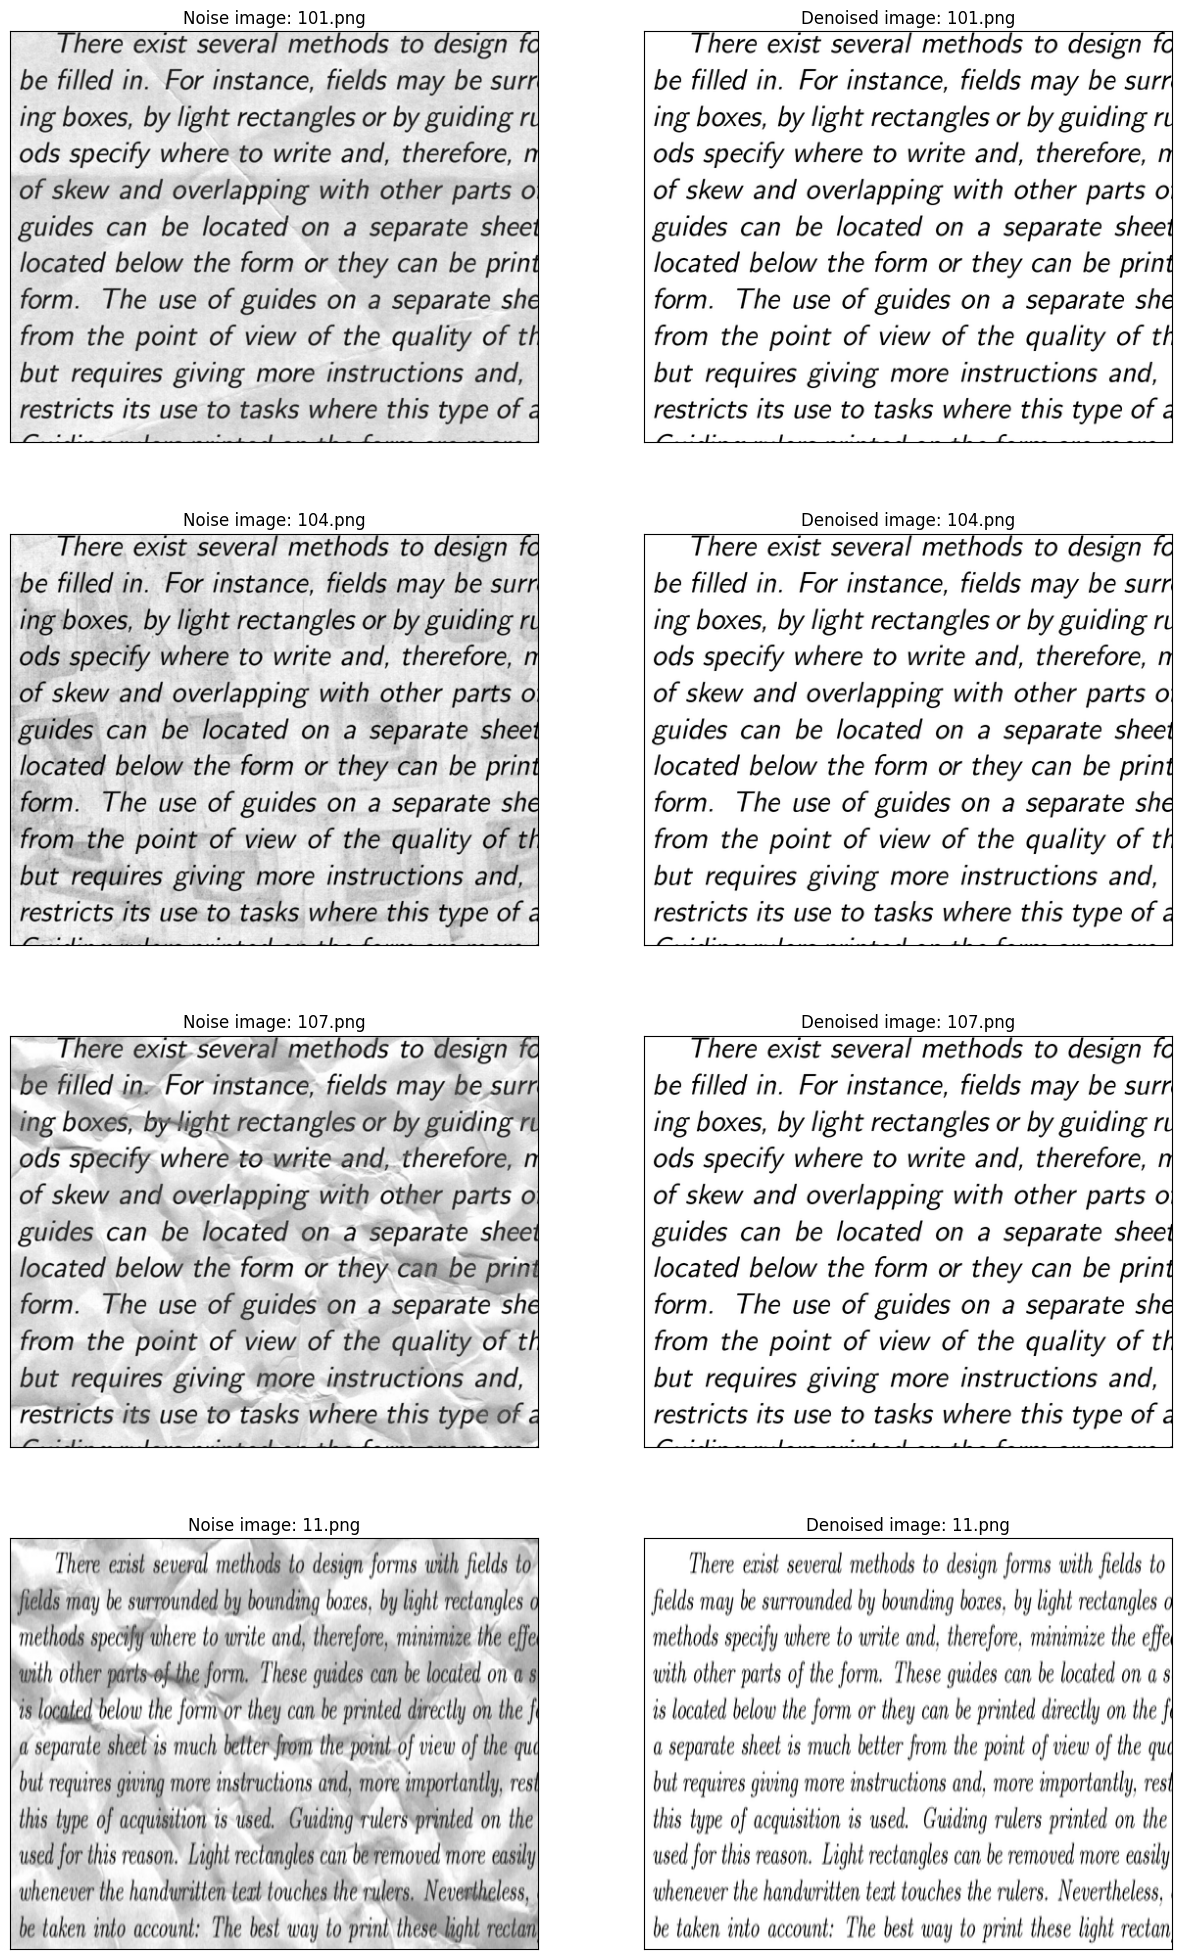

In [9]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))

    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

In [10]:
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

Используется оптимизатор Adam (так как он показал наилучшие результаты среди других оптимизаторов), функция потерь основана на среднем квадрате ошибки, а также отслеживаем среднюю абсолютную ошибку.

In [11]:
def model():
    input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 420, 540, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 420, 540, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 420, 540, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 420, 540, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 210, 270, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 210, 270, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 210, 270, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 210, 270, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 210, 270, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 420, 540, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 420, 540, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,217 (1.13 MB)

 Trainable params: 296,833 (1.13 MB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
callback = EarlyStopping(monitor='loss', patience=10)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=80, batch_size=12, verbose=1, callbacks=[callback])

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 420, 540, 1))
  warnings.warn(msg)


11/11 ━━━━━━━━━━━━━━━━━━━━ 99s 6s/step - loss: 0.1601 - mae: 0.3052 - val_loss: 0.1789 - val_mae: 0.4111
Epoch 2/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 580ms/step - loss: 0.0539 - mae: 0.1656 - val_loss: 0.1259 - val_mae: 0.3433
Epoch 3/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 549ms/step - loss: 0.0358 - mae: 0.1303 - val_loss: 0.0878 - val_mae: 0.2733
Epoch 4/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 553ms/step - loss: 0.0284 - mae: 0.1127 - val_loss: 0.0721 - val_mae: 0.2249
Epoch 5/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 561ms/step - loss: 0.0232 - mae: 0.1006 - val_loss: 0.0688 - val_mae: 0.1930
Epoch 6/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 567ms/step - loss: 0.0197 - mae: 0.0947 - val_loss: 0.0695 - val_mae: 0.1708
Epoch 7/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 601ms/step - loss: 0.0165 - mae: 0.0858 - val_loss: 0.0708 - val_mae: 0.1560
Epoch 8/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 605ms/step - loss: 0.0136 - mae: 0.0792 - val_loss: 0.0722 - val_mae: 0.1458
Epoch 9/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 609ms/step - loss: 0.

In [14]:
model.save_weights('my_checkpoint.weights.h5')

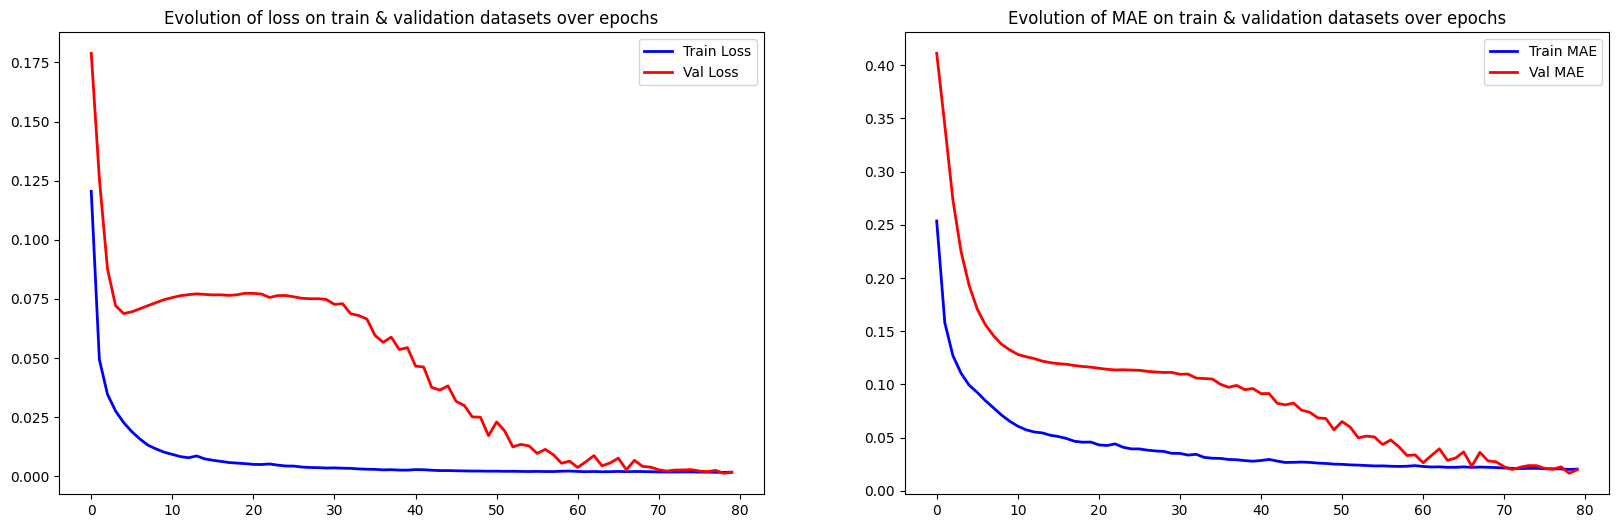

In [15]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [16]:
Y_test = model.predict(X_test[:4])

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4, 420, 540, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


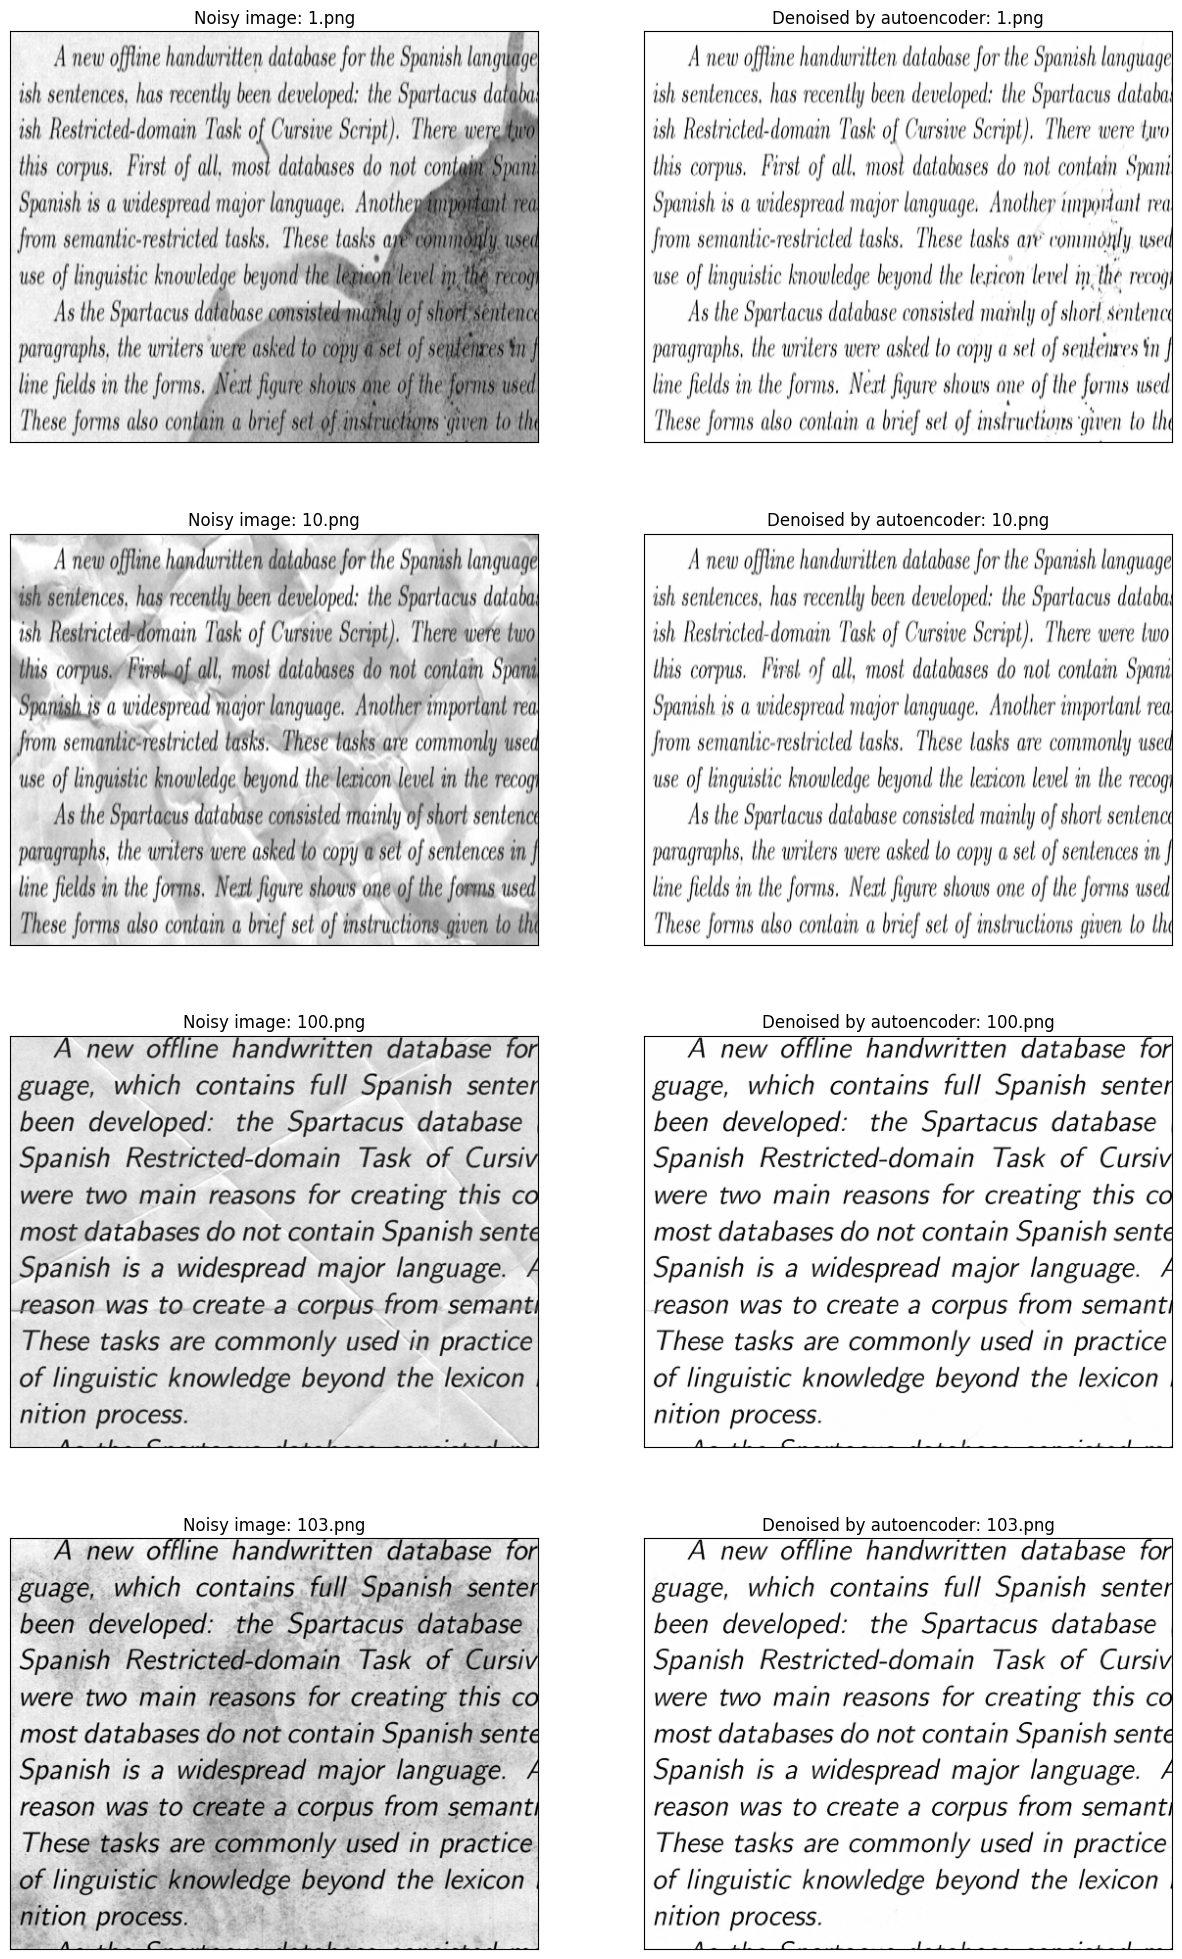

In [17]:
plt.figure(figsize=(15,25))

for i in range(0,8,2):
  index = int(i/2)
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_test[index][:,:,0], cmap='gray')
  plt.title('Noisy image: {}'.format(test_img[index]))

  plt.subplot(4,2,i+2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(Y_test[index][:,:,0], cmap='gray')
  plt.title('Denoised by autoencoder: {}'.format(test_img[index]))

plt.show()